1. Policyholder Information: This includes demographic details such as age,
gender, occupation, marital status, and geographical location.
2. Claim History: Information regarding past insurance claims, including claim
amounts, types of claims (e.g., medical, automobile), frequency of claims, and
claim durations.
3. Policy Details: Details about the insurance policies held by the policyholders,
such as coverage type, policy duration, premium amount, and deductibles.
4. Risk Factors: Variables indicating potential risk factors associated with
policyholders, such as credit score, driving record (for automobile insurance),
health status (for medical insurance), and property characteristics (for home
insurance).
5. External Factors: Factors external to the policyholders that may influence claim
likelihood, such as economic indicators, weather conditions, and regulatory
changes

## Data Preprocessing 

In [131]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest
from mlxtend.frequent_patterns import apriori, association_rules
import plotly.express as px

# Load the dataset
df = pd.read_csv('data.csv')

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

continuous_features = ['vehicle_age', 'customer_age', 
                      'displacement', 'turning_radius', 'length', 'width', 'gross_weight']
scaler = StandardScaler()
df[continuous_features] = scaler.fit_transform(df[continuous_features])

# Display summary statistics of standardized features
print("\nSummary statistics of standardized features:")
print(df[continuous_features].describe())

# Define categorical features - these are columns with text or categorical values
categorical_features = ['region_code', 'segment', 'model', 'fuel_type', 'engine_type', 
                       'airbags', 'rear_brakes_type', 'cylinder', 'transmission_type',
                       'steering_type']

# Encode categorical variables
for column in categorical_features:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

# Display first few rows of processed dataset
print("\nFirst few rows of processed dataset:")
display(df.head())

# Basic statistics of the processed dataset
print("\nProcessed dataset statistics:")
print(df.describe())

# Save the cleaned dataset
df.to_csv('cleaned_insurance_claims.csv', index=False)
print("\nCleaned dataset saved successfully!")

# Extract INT?/FLOAT from String max_power
df['rpm'] = df['max_power'].str.extract(r'@(\d+)rpm').astype(int)
df["horse_power"] = df['max_power'].str.extract(r'(\d+\.\d+)').astype(float)


Missing values in each column:
policy_id                           0
subscription_length                 0
vehicle_age                         0
customer_age                        0
region_code                         0
region_density                      0
segment                             0
model                               0
fuel_type                           0
max_torque                          0
max_power                           0
engine_type                         0
airbags                             0
is_esc                              0
is_adjustable_steering              0
is_tpms                             0
is_parking_sensors                  0
is_parking_camera                   0
rear_brakes_type                    0
displacement                        0
cylinder                            0
transmission_type                   0
steering_type                       0
turning_radius                      0
length                              0
width             

,policy_id,subscription_length,vehicle_age,customer_age,region_code,region_density,segment,model,fuel_type,max_torque,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,claim_status
0,POL045360,9.3,-0.166143,-0.551353,20,8794,4,5,1,250Nm@2750rpm,...,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,3,0
1,POL016745,8.2,0.362770,-1.416462,11,27003,3,10,1,200Nm@1750rpm,...,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,4,0
2,POL007194,9.5,-1.047663,-0.118799,20,8794,4,5,1,250Nm@2750rpm,...,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,3,0
3,POL018146,5.2,-0.871359,-0.118799,1,73430,0,0,0,60Nm@3500rpm,...,No,No,No,Yes,No,No,No,Yes,0,0
4,POL049011,10.1,-0.342447,1.611418,4,5410,2,6,1,200Nm@3000rpm,...,No,Yes,Yes,Yes,No,No,Yes,Yes,5,0



Processed dataset statistics:
       subscription_length   vehicle_age  customer_age   region_code  \
count         58592.000000  5.859200e+04  5.859200e+04  58592.000000   
mean              6.111688 -2.053700e-16  1.250896e-16     13.035653   
std               4.142790  1.000009e+00  1.000009e+00      6.803915   
min               0.000000 -1.223968e+00 -1.416462e+00      0.000000   
25%               2.100000 -8.713593e-01 -8.397228e-01      6.000000   
50%               5.700000 -1.661427e-01 -1.187989e-01     15.000000   
75%              10.400000  7.153780e-01  6.021250e-01     20.000000   
max              14.000000  1.640645e+01  4.350929e+00     21.000000   

       region_density       segment         model     fuel_type   engine_type  \
count    58592.000000  58592.000000  58592.000000  58592.000000  58592.000000   
mean     18826.858667      1.938644      4.659237      1.003448      5.502748   
std      17660.174792      1.566329      3.197355      0.835104      2.684796

# Task 1: Data Cleaning and Initial Processing

# Task 2: Exploratory Data Analysis (EDA)

## Risk Segmentation

# Task 1: Customer Segmentation

In [132]:
# Generic Functions for future use

def CalculteOptimalClusters(data, max_clusters: int, sample_size: float, columns_names: list = None, print: bool = False):
    # Calculates sillhoute score by using KMeans clustering repeatedly and picking the most optimal number of clusters
    cluster_range = range(2, max_clusters)
    silhouette_scores = []

    if columns_names is not None:
        subset = data[columns_names]
    else:
        subset = data

    subset = subset.sample(frac=sample_size, random_state=42)  # Use a sample of the data for faster computation (VERY LONG IF FULL)
    for num_clusters in cluster_range:
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(subset)
        silhouette_avg = silhouette_score(subset, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        
    if print:   # If user wants to print the graph
        PlotSilhouetteScore(cluster_range, silhouette_scores)
    
    return cluster_range[silhouette_scores.index(max(silhouette_scores))]



def PlotSilhouetteScore(cluster_range, silhouette_scores):
    plt.figure(figsize=(10, 8))
    plt.plot(cluster_range, silhouette_scores, marker='o')
    plt.title('Silhouette Score Method for Optimal Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.show()

def PlotClusters(data, x_col, y_col, cluster_col, title, xlabel, ylabel, palette='viridis'):
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=data, x=x_col, y=y_col, hue=cluster_col, palette=palette)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(title=cluster_col)
    plt.show()


def CreateCluster(data, num_clusters, cluster_category: str, list_columns: list = None):
    if list_columns is None:
        list_columns = data.columns
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    data[cluster_category] = kmeans.fit_predict(data[list_columns])


No features that have a high correlation with claim_status

In [134]:
scaler = StandardScaler()
risk_profile= pd.DataFrame(scaler.fit_transform(risk_profile), columns=risk_profile.columns)
display(risk_profile.head())

,vehicle_age,horse_power,rpm,ncap_rating,customer_age,region_code,region_density,subscription_length,claim_status
0,-0.166143,1.244565,-1.425846,0.892402,-0.551353,1.023588,-0.568111,0.769612,-0.261418
1,0.362770,0.682812,-1.862164,1.612052,-1.416462,-0.299191,0.462975,0.504088,-0.261418
2,-1.047663,1.244565,-1.425846,0.892402,-0.118799,1.023588,-0.568111,0.817889,-0.261418
3,-0.871359,-1.394156,0.755743,-1.266548,-0.118799,-1.768946,3.091906,-0.220068,-0.261418
4,-0.342447,0.353559,-1.425846,2.331701,1.611418,-1.328019,-0.759730,0.962720,-0.261418


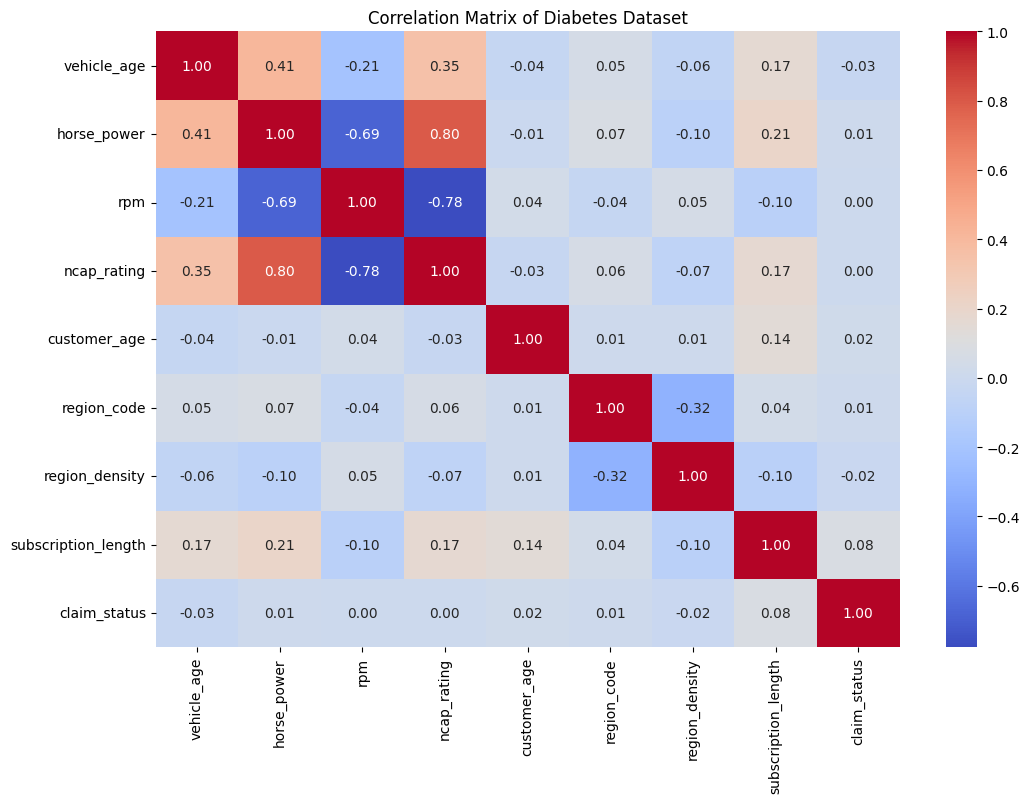

In [135]:
correlation_matrix = risk_profile.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Diabetes Dataset')
plt.show()

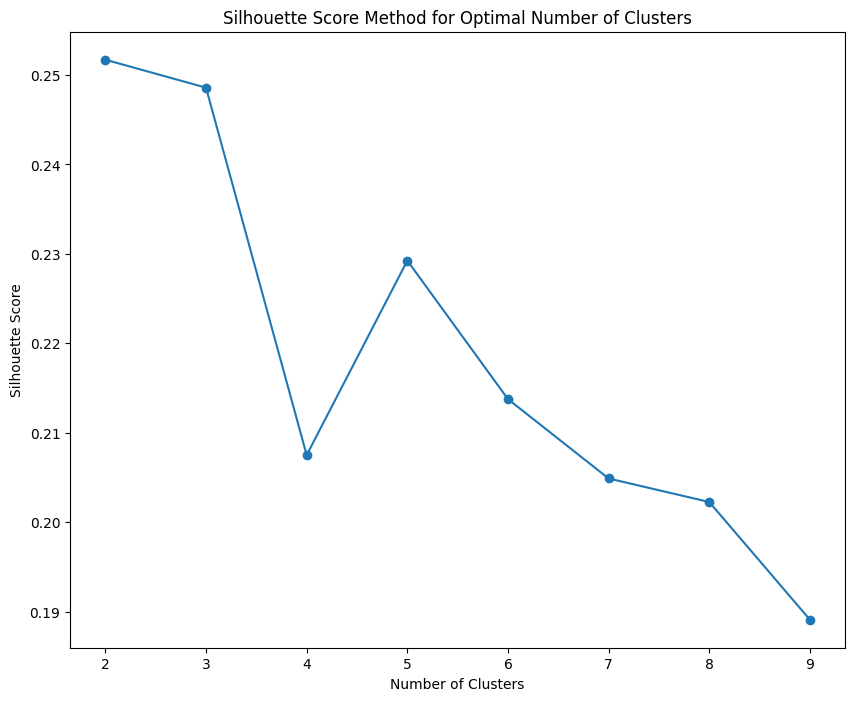

In [136]:
# Used as a base cluster that takes into account all categories
num_clusters = CalculteOptimalClusters(risk_profile, 10, 0.25, print=True)
CreateCluster(risk_profile, num_clusters, 'risk_cluster')

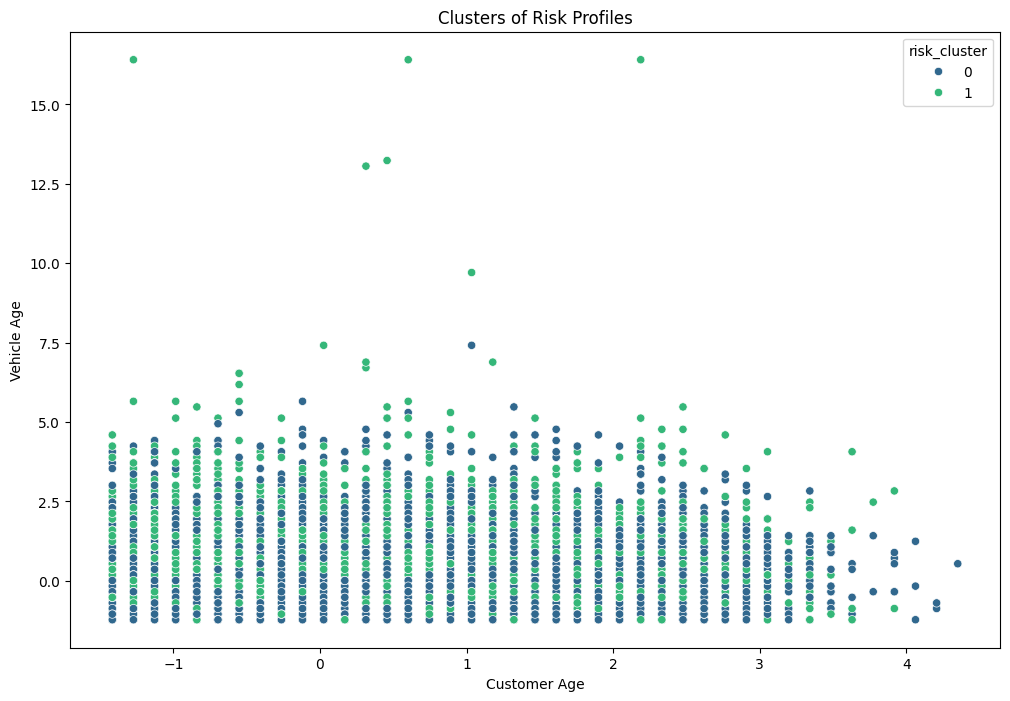

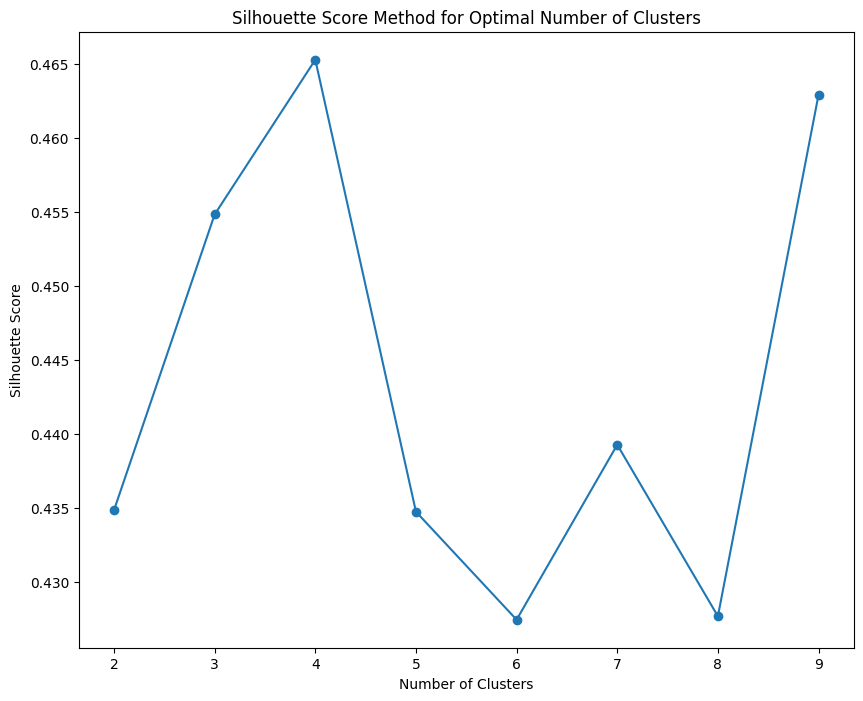

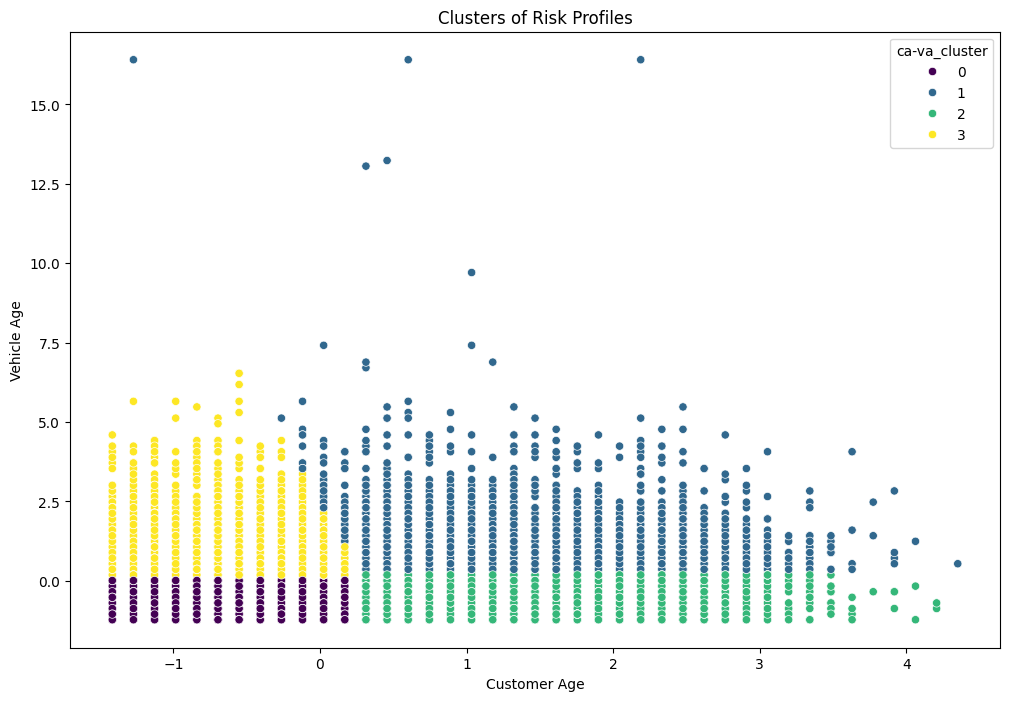

In [137]:
PlotClusters(risk_profile, 'customer_age', 'vehicle_age', 'risk_cluster', 'Clusters of Risk Profiles', 'Customer Age', 'Vehicle Age')

num_clusters = CalculteOptimalClusters(risk_profile[['customer_age', 'horse_power']], 10, 0.25, print=True)
CreateCluster(risk_profile, num_clusters, 'ca-va_cluster', ['customer_age', 'vehicle_age'])
PlotClusters(risk_profile, 'customer_age', 'vehicle_age', 'ca-va_cluster', 'Clusters of Risk Profiles', 'Customer Age', 'Vehicle Age')

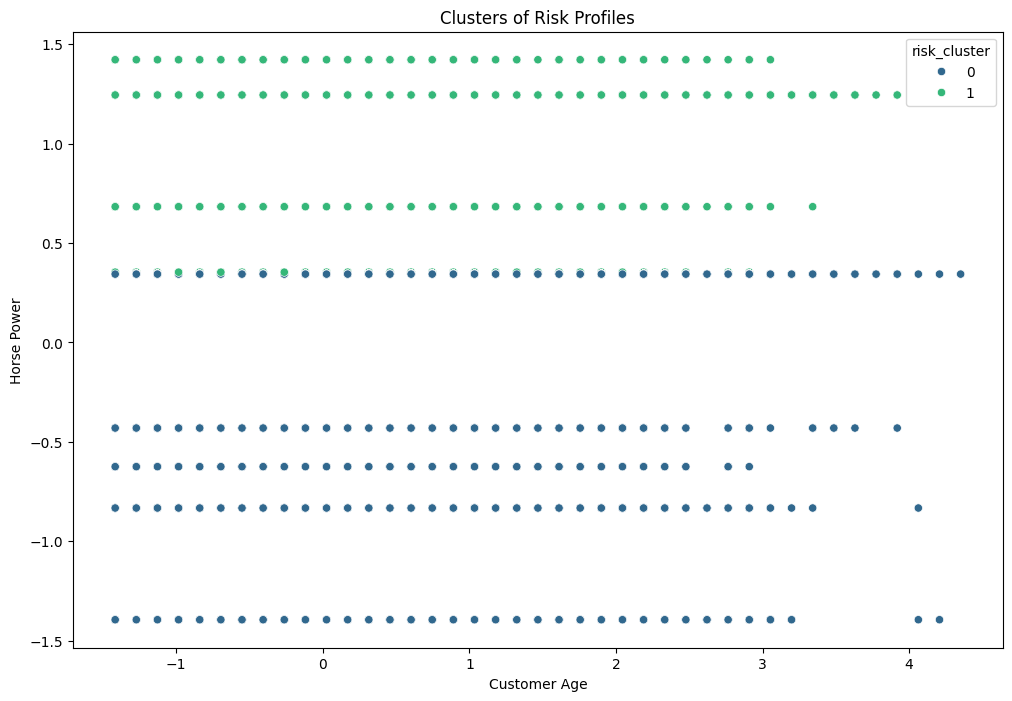

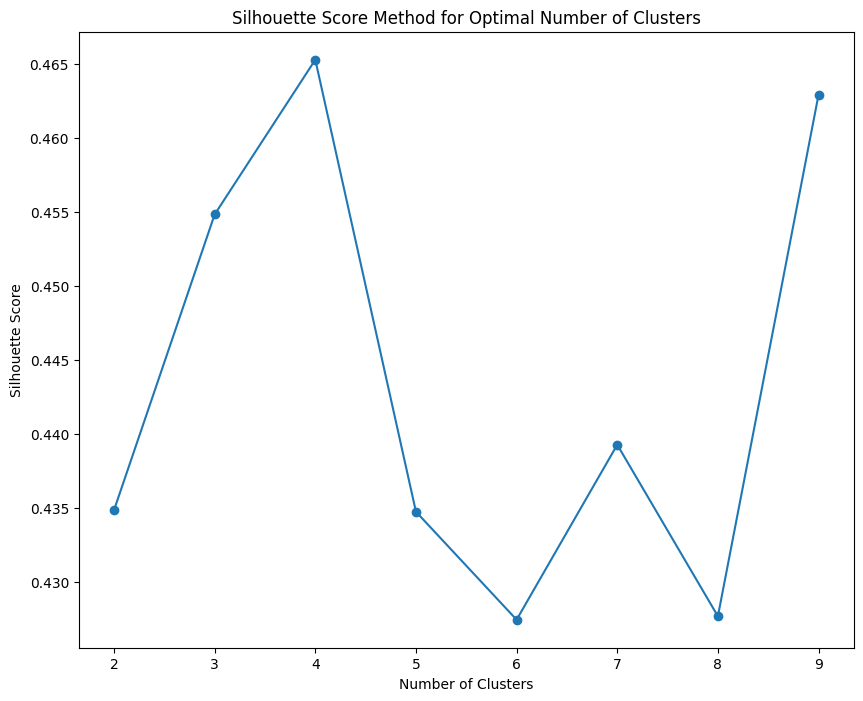

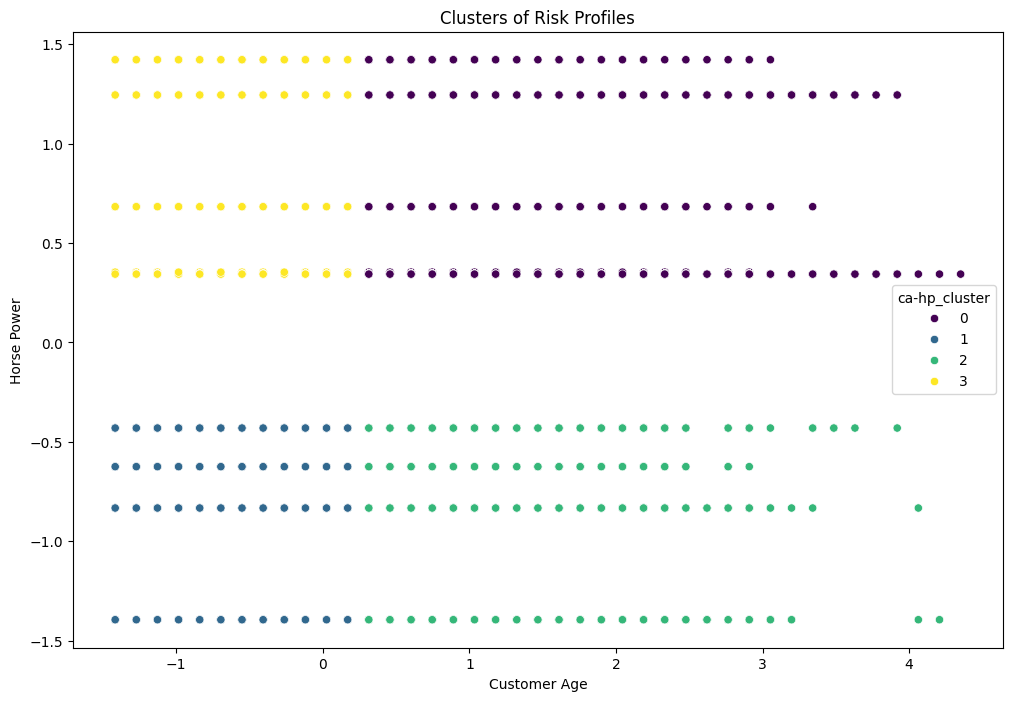

In [138]:
PlotClusters(risk_profile, 'customer_age', 'horse_power', 'risk_cluster', 'Clusters of Risk Profiles', 'Customer Age', 'Horse Power')

num_clusters = CalculteOptimalClusters(risk_profile[['customer_age', 'horse_power']], 10, 0.25, print=True)
CreateCluster(risk_profile, num_clusters, 'ca-hp_cluster', ['customer_age', 'horse_power'])
PlotClusters(risk_profile, 'customer_age', 'horse_power', 'ca-hp_cluster', 'Clusters of Risk Profiles', 'Customer Age', 'Horse Power')

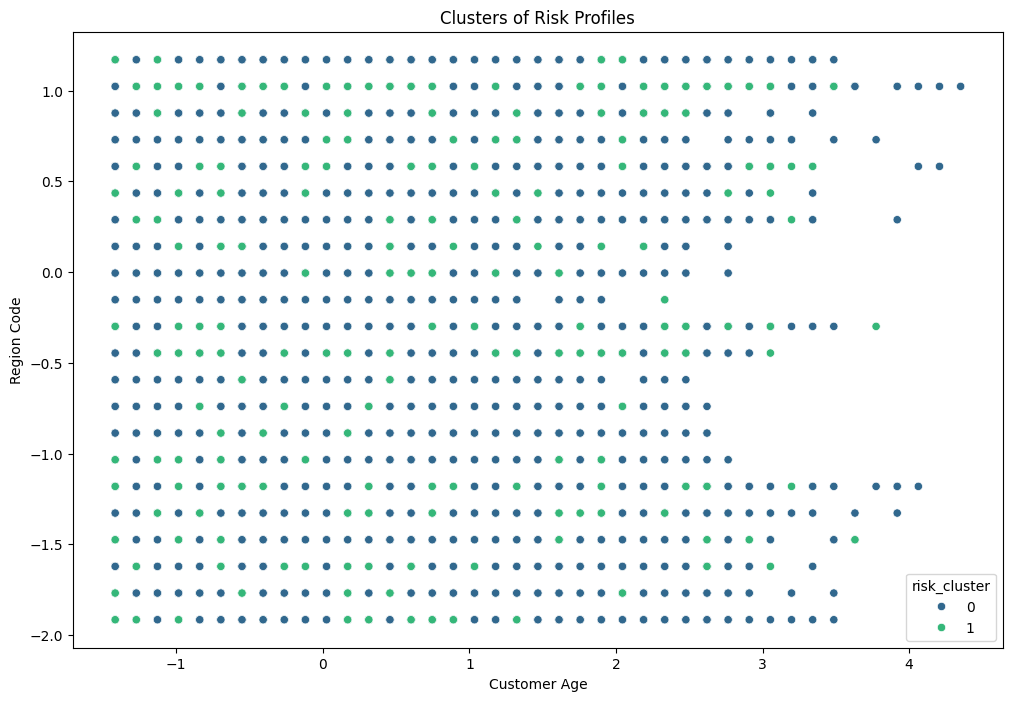

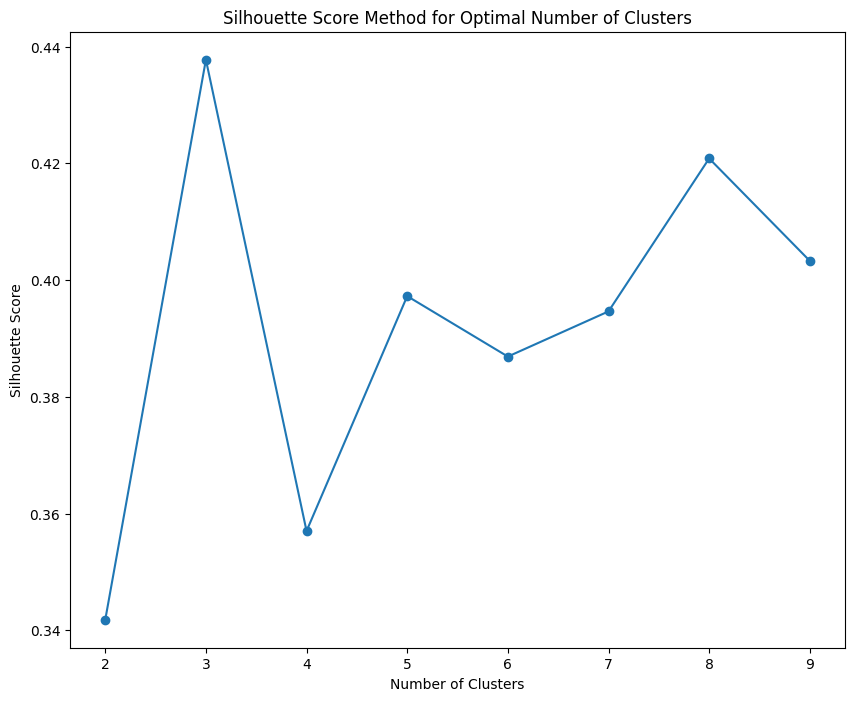

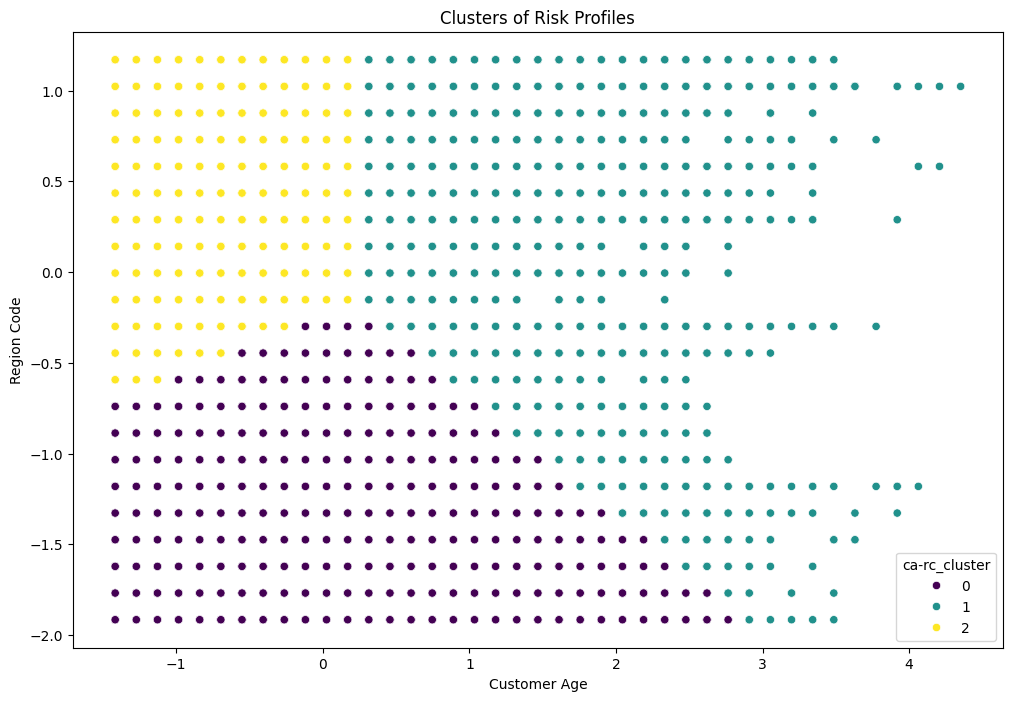

In [139]:
PlotClusters(risk_profile, 'customer_age', 'region_code', 'risk_cluster', 'Clusters of Risk Profiles', 'Customer Age', 'Region Code')

num_clusters = CalculteOptimalClusters(risk_profile[['customer_age', 'region_code']], 10, 0.25, print=True)
CreateCluster(risk_profile, num_clusters, 'ca-rc_cluster', ['customer_age', 'region_code'])
PlotClusters(risk_profile, 'customer_age', 'region_code', 'ca-rc_cluster', 'Clusters of Risk Profiles', 'Customer Age', 'Region Code')

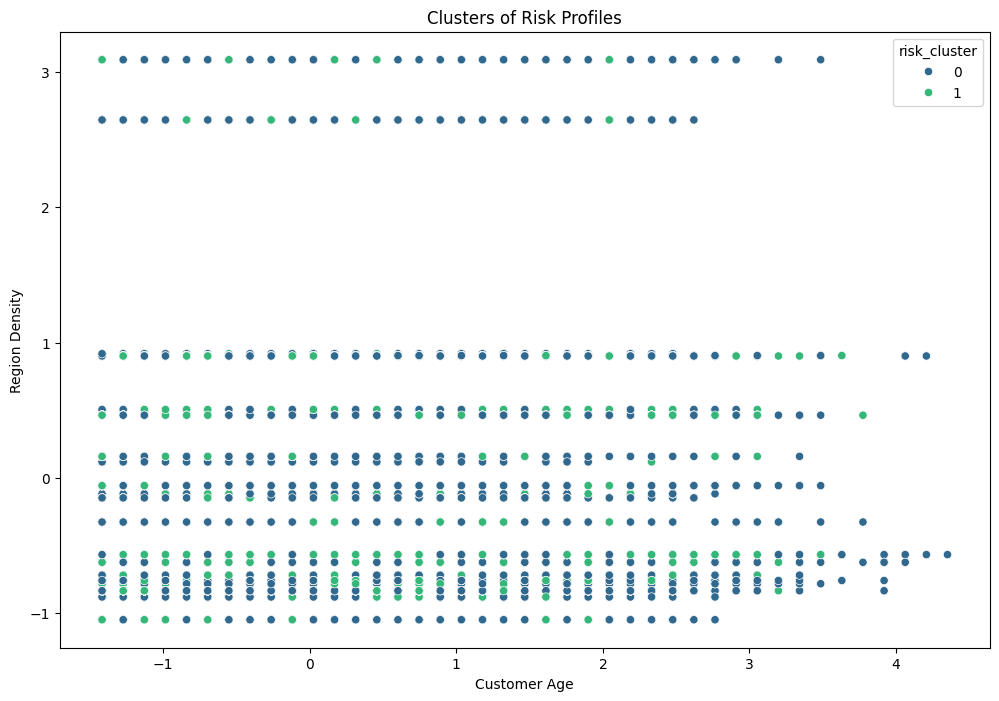

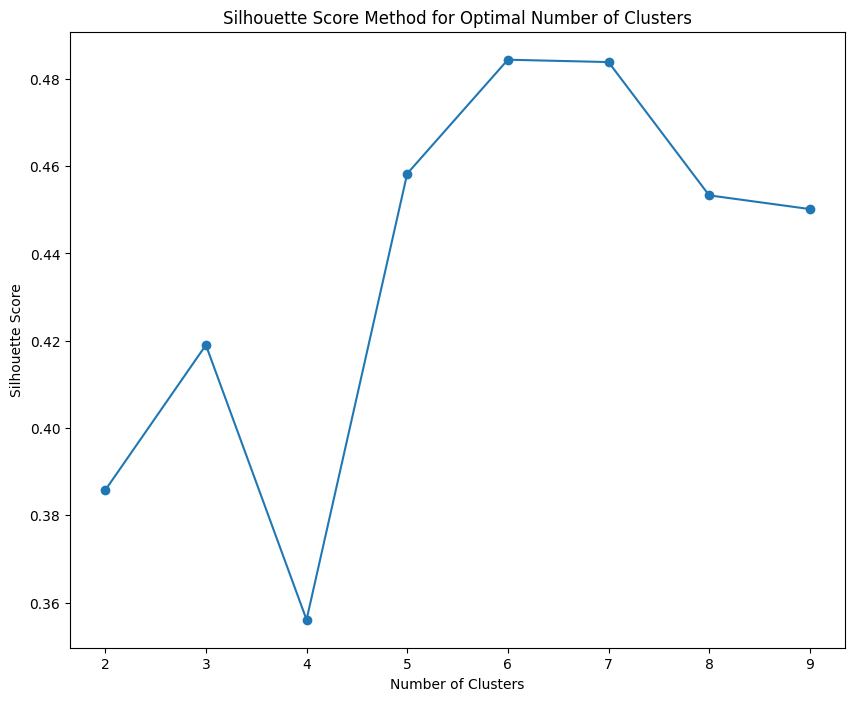

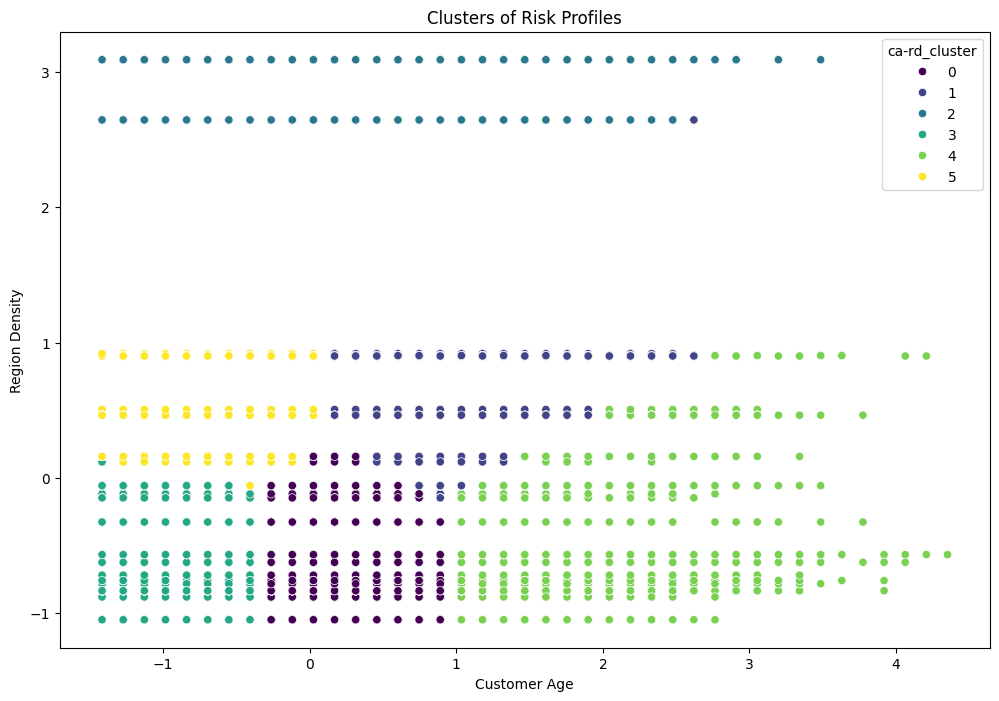

In [140]:
PlotClusters(risk_profile, 'customer_age', 'region_density', 'risk_cluster', 'Clusters of Risk Profiles', 'Customer Age', 'Region Density')

num_clusters = CalculteOptimalClusters(risk_profile[['customer_age', 'region_density']], 10, 0.25, print=True)
CreateCluster(risk_profile, num_clusters, 'ca-rd_cluster', ['customer_age', 'region_density'])
PlotClusters(risk_profile, 'customer_age', 'region_density', 'ca-rd_cluster', 'Clusters of Risk Profiles', 'Customer Age', 'Region Density')

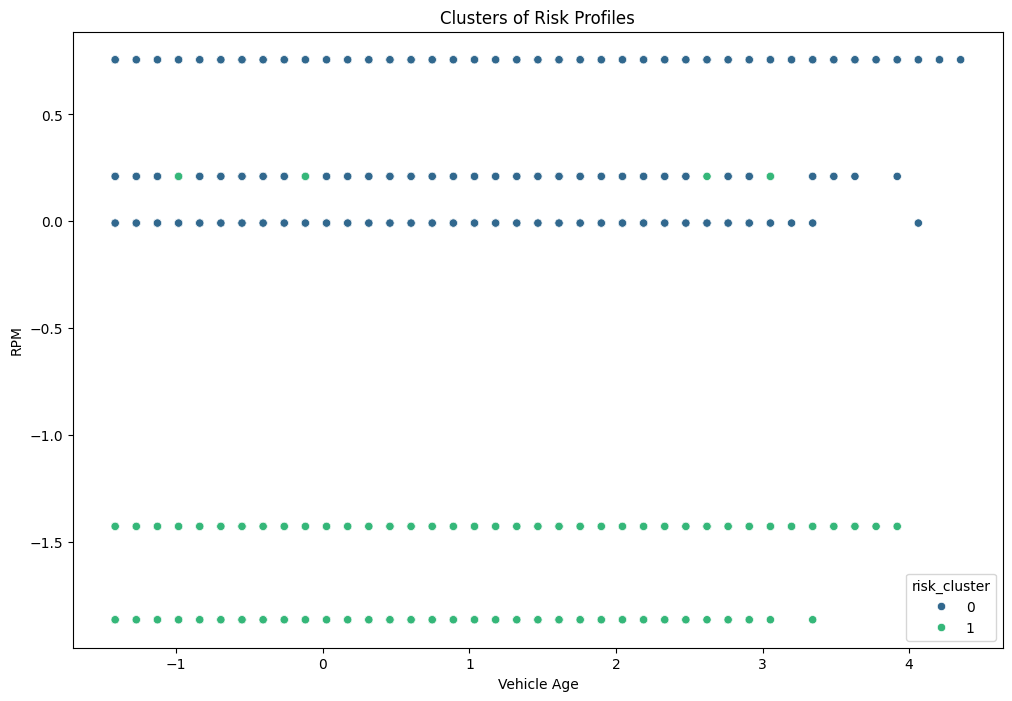

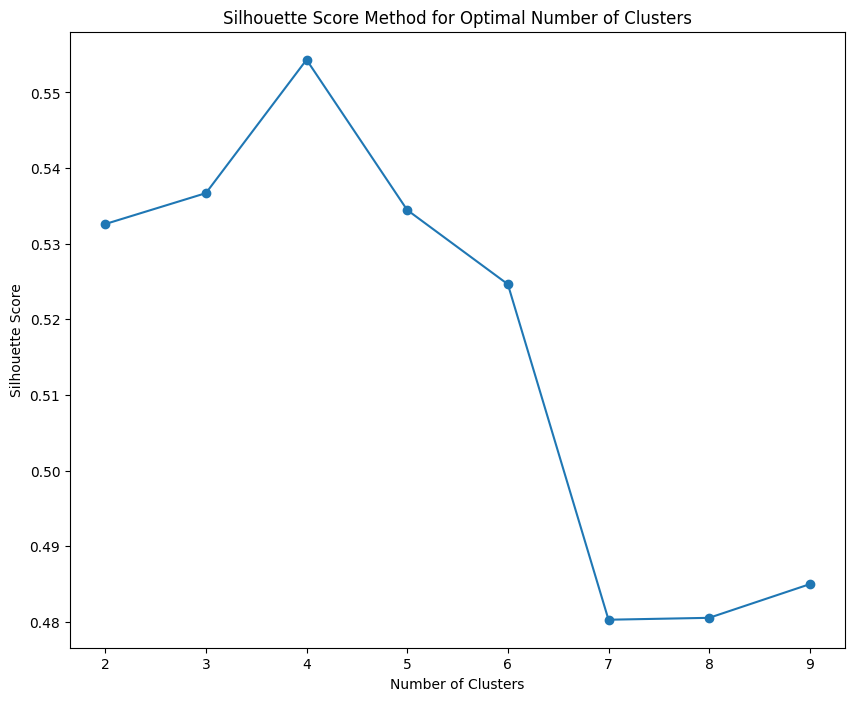

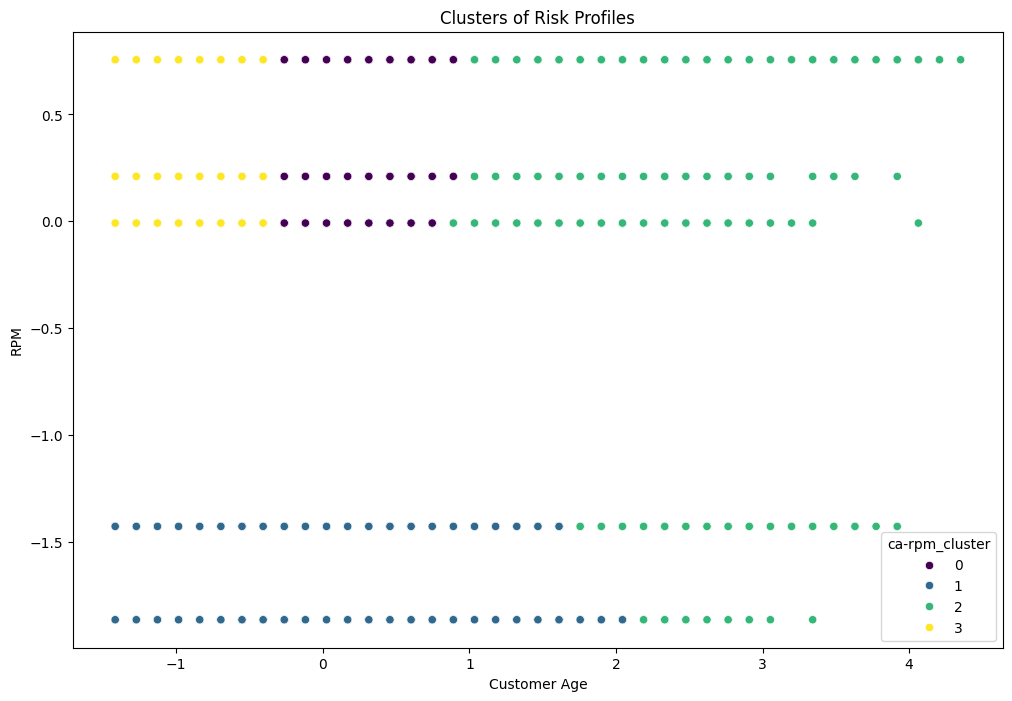

In [141]:
PlotClusters(risk_profile, 'customer_age', 'rpm', 'risk_cluster', 'Clusters of Risk Profiles', 'Vehicle Age', 'RPM')

num_clusters = CalculteOptimalClusters(risk_profile[['customer_age', 'rpm']], 10, 0.25, print=True)
CreateCluster(risk_profile, num_clusters, 'ca-rpm_cluster', ['customer_age', 'rpm'])
PlotClusters(risk_profile, 'customer_age', 'rpm', 'ca-rpm_cluster', 'Clusters of Risk Profiles', 'Customer Age', 'RPM')

# Task 2: Anomaly Detection

In [142]:
data = df.copy()
safety_features = [ # Features of Interest
    'airbags',
    'is_parking_sensors', 'is_parking_camera', 'is_front_fog_lights',
    'is_central_locking', 'is_speed_alert', 'rear_brakes_type',
    'model', 'transmission_type', 'steering_type', 'is_brake_assist', 'is_power_steering',
    'ncap_rating'
]

for feature in safety_features: # Convert Yes/No to 1/0
    data[feature] = data[feature].replace({'Yes': 1, 'No': 0}).astype(int)

/var/folders/y2/n8qdd_353kb3y187qkv9729c0000gn/T/ipykernel_11724/4063297837.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[feature] = data[feature].replace({'Yes': 1, 'No': 0}).astype(int)
/var/folders/y2/n8qdd_353kb3y187qkv9729c0000gn/T/ipykernel_11724/4063297837.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[feature] = data[feature].replace({'Yes': 1, 'No': 0}).astype(int)
/var/folders/y2/n8qdd_353kb3y187qkv9729c0000gn/T/ipykernel_11724/4063297837.py:11: FutureWarning: Downcasting behavior in `replace` is d

In [143]:
for feature in safety_features:
    data[feature] = data[feature].replace({'Yes': 1, 'No': 0}).astype(int)

# Result DF
anomaly_counts = pd.DataFrame(columns=['Feature', 'Anomaly_Count'])

for feature in safety_features:
    df_subset = data[[feature, 'claim_status']].copy()  # Iterates through each feature and the target variable claim_status
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_subset)

    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    df_subset['anomaly'] = iso_forest.fit_predict(X_scaled)
    
    anomaly_count = (df_subset['anomaly'] == -1).sum()  # -1 label indiciates anomalies
    
    new_row = pd.DataFrame({'Feature': [feature], 'Anomaly_Count': [anomaly_count]})
    anomaly_counts = pd.concat([anomaly_counts, new_row], ignore_index=True)

anomaly_counts = anomaly_counts.sort_values(by='Anomaly_Count', ascending=False)

# Display the top 3 features with the highest anomalies when compared to the target variable claim_status
top_3_features = anomaly_counts.head(3)
print("Top 3 Safety Features with Highest Anomalies:")
print(top_3_features)

Top 3 Safety Features with Highest Anomalies:
               Feature Anomaly_Count
9        steering_type          2806
1   is_parking_sensors          2373
12         ncap_rating          2357


Top 5 Safety Features with Highest Anomalies:
               Feature Anomaly_Count
9        steering_type          2806
1   is_parking_sensors          2373
12         ncap_rating          2357
0              airbags          2311
7                model          2256


/var/folders/y2/n8qdd_353kb3y187qkv9729c0000gn/T/ipykernel_11724/222355800.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Feature', y='Anomaly_Count', data=top_5_features, palette='viridis')


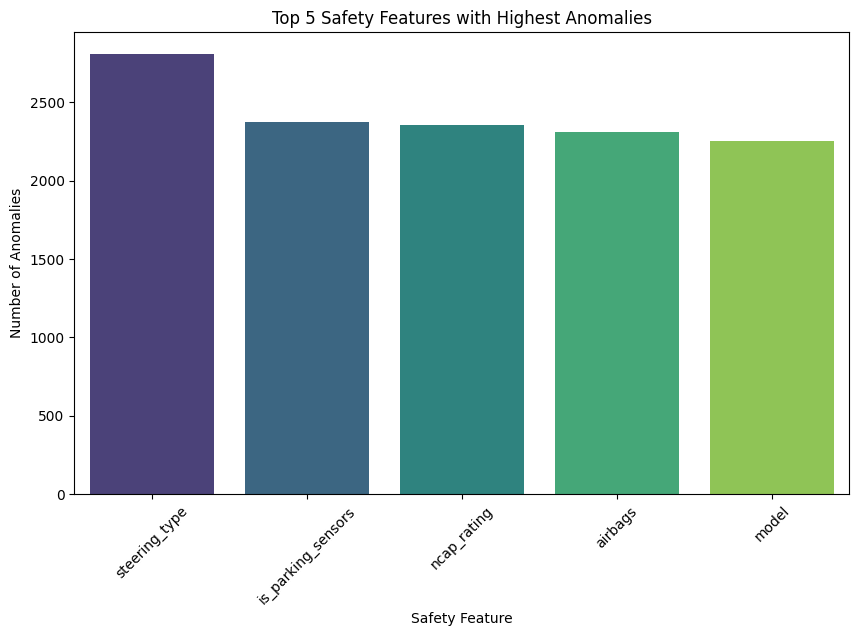

In [144]:
top_5_features = anomaly_counts.sort_values(by='Anomaly_Count', ascending=False).head(5)
print("Top 5 Safety Features with Highest Anomalies:")
print(top_5_features)

plt.figure(figsize=(10, 6))
sns.barplot(x='Feature', y='Anomaly_Count', data=top_5_features, palette='viridis')
plt.title('Top 5 Safety Features with Highest Anomalies')
plt.xlabel('Safety Feature')
plt.ylabel('Number of Anomalies')
plt.xticks(rotation=45)
plt.show()

/var/folders/y2/n8qdd_353kb3y187qkv9729c0000gn/T/ipykernel_11724/1759574847.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['is_parking_sensors'] = data['is_parking_sensors'].replace({'Yes': 1, 'No': 0}).astype(int)


Top 10 Region-Feature Relationships with Highest Outliers:
    Region        Feature  Outliers
64      14    ncap_rating        15
62       7    ncap_rating         8
59       3    ncap_rating         7
65      12    ncap_rating         7
18       7  steering_type         7
46       1    ncap_rating         6
17      13  steering_type         5
61      13    ncap_rating         5
21      12  steering_type         5
87      12          model         5


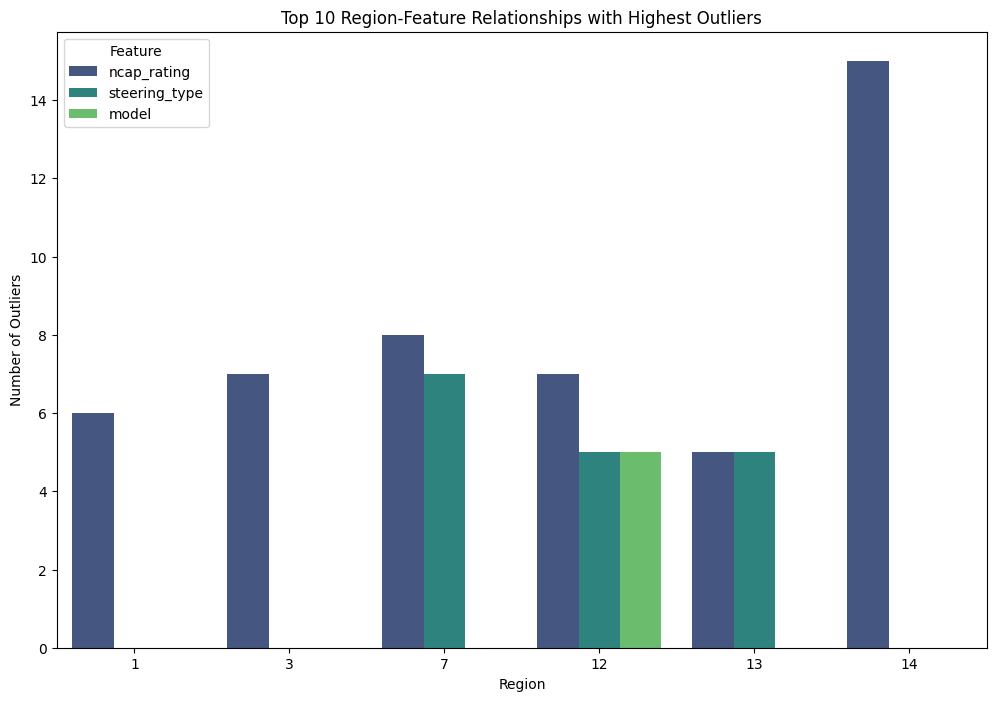

In [145]:
# Preprocessing
data = df.copy()
data['region_code'] = data['region_code'].astype(int)

features = ['steering_type', 'is_parking_sensors', 'ncap_rating', 'model']
data = data.dropna(subset=features + ['region_code', 'claim_status'])

if data['is_parking_sensors'].dtype == object:      ## !!!!!!! REPLACE?
    data['is_parking_sensors'] = data['is_parking_sensors'].replace({'Yes': 1, 'No': 0}).astype(int)

categorical_features = ['steering_type', 'model']
label_encoders = {}
for feature in categorical_features:
    le = LabelEncoder()
    data[feature] = le.fit_transform(data[feature])
    label_encoders[feature] = le

data['ncap_rating'] = data['ncap_rating'].astype(float)

region_details = []

# Loop Through Features and Regions - Find amount of outlines per each combination
regions = data['region_code'].unique()
for feature in features:
    total_outliers = 0
    for region in regions:
        region_data = data[data['region_code'] == region]
        if len(region_data) < 5:
            continue
        X = region_data[[feature, 'claim_status']]
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        dbscan = DBSCAN(eps=0.5, min_samples=5)
        labels = dbscan.fit_predict(X_scaled)
        num_outliers = np.sum(labels == -1)
        total_outliers += num_outliers
        region_details.append({'Region': region, 'Feature': feature, 'Outliers': num_outliers})


region_feature_outliers = pd.DataFrame(region_details)
top_10_region_features = region_feature_outliers.sort_values(by='Outliers', ascending=False).head(10)
print("Top 10 Region-Feature Relationships with Highest Outliers:")
print(top_10_region_features)


# Step 5: Visualize Results
plt.figure(figsize=(12, 8))
sns.barplot(x='Region', y='Outliers', hue='Feature', data=top_10_region_features, palette='viridis')
plt.title('Top 10 Region-Feature Relationships with Highest Outliers')
plt.xlabel('Region')
plt.ylabel('Number of Outliers')
plt.legend(title='Feature')
plt.show()

## Predictive Modeling

# Task 1: Classification Model

# Task 2: Model Evaluation

## Association (?)

# Task 1: Association Rule Mining

In [146]:

# Binning
df['region_density_bin'] = pd.qcut(df['region_density'], q=3, labels=["Low", "Medium", "High"])
df['horse_power_bin'] = pd.qcut(df['horse_power'], q=3, labels=["LowHP", "MedHP", "HighHP"])
df['rpm_bin'] = pd.qcut(df['rpm'], q=3, labels=["LowRPM", "HighRPM"], duplicates='drop')
df['displacement_bin'] = pd.qcut(df['displacement'], q=3, labels=["SmallDisp", "MedDisp", "LargeDisp"])

cols_of_interest = [
    'region_density_bin', 'model', 'rear_brakes_type', 
    'transmission_type', 'horse_power_bin', 'rpm_bin', 
    'ncap_rating', 'displacement_bin', 'claim_status'
]
df_sub = df[cols_of_interest]

df_encoded = pd.get_dummies(df_sub, columns=[
    'region_density_bin', 'model', 'rear_brakes_type', 
    'transmission_type', 'horse_power_bin', 'rpm_bin', 
    'ncap_rating', 'displacement_bin', 'claim_status'
])

frequent_itemsets = apriori(df_encoded, min_support=0.01, use_colnames=True)

In [149]:
# Generating Rules
lift_rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
confidence_rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
support_rules = association_rules(frequent_itemsets, metric="support", min_threshold=0.01)

lift_rules['antecedents'] = lift_rules['antecedents'].apply(lambda x: ', '.join(list(x)))
lift_rules['consequents'] = lift_rules['consequents'].apply(lambda x: ', '.join(list(x)))

# Top 10 Rules by Lift
top_lift = lift_rules.sort_values(by='lift', ascending=False).head(10)
print("Top 10 Rules by Lift:")
display(top_lift[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

# Top 10 Rules by Confidence
top_confidence = confidence_rules.sort_values(by='confidence', ascending=False).head(10)
print("\nTop 10 Rules by Confidence:")
display(top_confidence[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

# Top 10 Rules by Support
top_support = support_rules.sort_values(by='support', ascending=False).head(10)
print("\nTop 10 Rules by Support:")
display(top_support[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

Top 10 Rules by Lift:


,antecedents,consequents,support,confidence,lift
141314,"transmission_type_0, displacement_bin_MedDisp,...","horse_power_bin_MedHP, model_3",0.018433,1.0,54.251852
142302,"model_3, claim_status_0, rpm_bin_HighRPM","transmission_type_0, displacement_bin_MedDisp,...",0.017067,1.0,54.251852
61575,"transmission_type_0, displacement_bin_MedDisp,...","horse_power_bin_MedHP, model_3",0.018433,1.0,54.251852
61590,"horse_power_bin_MedHP, model_3","transmission_type_0, displacement_bin_MedDisp,...",0.018433,1.0,54.251852
61596,model_3,"horse_power_bin_MedHP, transmission_type_0, di...",0.018433,1.0,54.251852
225016,"transmission_type_0, claim_status_0, displacem...","horse_power_bin_MedHP, model_3, rpm_bin_HighRPM",0.017067,1.0,54.251852
61655,"transmission_type_0, ncap_rating_2, displaceme...",model_3,0.018433,1.0,54.251852
224636,"horse_power_bin_MedHP, model_3, claim_status_0...","transmission_type_0, displacement_bin_MedDisp,...",0.017067,1.0,54.251852
271773,"model_3, claim_status_0, rpm_bin_HighRPM","rear_brakes_type_1, displacement_bin_MedDisp, ...",0.017067,1.0,54.251852
141501,"transmission_type_0, displacement_bin_MedDisp,...","model_3, rpm_bin_HighRPM",0.018433,1.0,54.251852



Top 10 Rules by Confidence:


,antecedents,consequents,support,confidence,lift
77390,"(model_7, horse_power_bin_MedHP, displacement_...","(transmission_type_1, rear_brakes_type_1, ncap...",0.235117,1.0,3.264360
48209,"(model_7, region_density_bin_Low, displacement...","(transmission_type_1, horse_power_bin_MedHP, n...",0.145276,1.0,4.253194
106103,"(model_5, region_density_bin_Medium, rear_brak...","(rpm_bin_LowRPM, ncap_rating_3, transmission_t...",0.044699,1.0,4.179769
106102,"(model_5, region_density_bin_Medium, horse_pow...","(rpm_bin_LowRPM, ncap_rating_3, rear_brakes_ty...",0.044699,1.0,4.179769
106101,"(model_5, region_density_bin_Medium, ncap_rati...","(rpm_bin_LowRPM, horse_power_bin_HighHP, trans...",0.044699,1.0,4.179769
106100,"(model_5, region_density_bin_Medium, ncap_rati...","(rpm_bin_LowRPM, rear_brakes_type_0, horse_pow...",0.044699,1.0,4.179769
106099,"(model_5, region_density_bin_Medium, ncap_rati...","(rpm_bin_LowRPM, rear_brakes_type_0, transmiss...",0.044699,1.0,4.179769
106098,"(rpm_bin_LowRPM, model_5, region_density_bin_M...","(ncap_rating_3, horse_power_bin_HighHP, transm...",0.044699,1.0,4.179769
106097,"(rpm_bin_LowRPM, model_5, region_density_bin_M...","(rear_brakes_type_0, ncap_rating_3, horse_powe...",0.044699,1.0,4.179769
106096,"(rpm_bin_LowRPM, model_5, region_density_bin_M...","(ncap_rating_3, rear_brakes_type_0, transmissi...",0.044699,1.0,4.179769



Top 10 Rules by Support:


,antecedents,consequents,support,confidence,lift
335,(rear_brakes_type_1),(claim_status_0),0.712162,0.936129,1.000103
334,(claim_status_0),(rear_brakes_type_1),0.712162,0.760831,1.000103
308,(transmission_type_1),(rear_brakes_type_1),0.651642,1.000000,1.314488
309,(rear_brakes_type_1),(transmission_type_1),0.651642,0.856576,1.314488
318,(rear_brakes_type_1),(rpm_bin_HighRPM),0.626178,0.823103,1.314488
319,(rpm_bin_HighRPM),(rear_brakes_type_1),0.626178,1.000000,1.314488
4495,"(transmission_type_1, rear_brakes_type_1)",(claim_status_0),0.610032,0.936146,1.000122
4499,(rear_brakes_type_1),"(transmission_type_1, claim_status_0)",0.610032,0.801880,1.314488
4498,(claim_status_0),"(transmission_type_1, rear_brakes_type_1)",0.610032,0.651721,1.000122
4497,(transmission_type_1),"(claim_status_0, rear_brakes_type_1)",0.610032,0.936146,1.314513


# Task 2: Sequential Pattern Analysis   

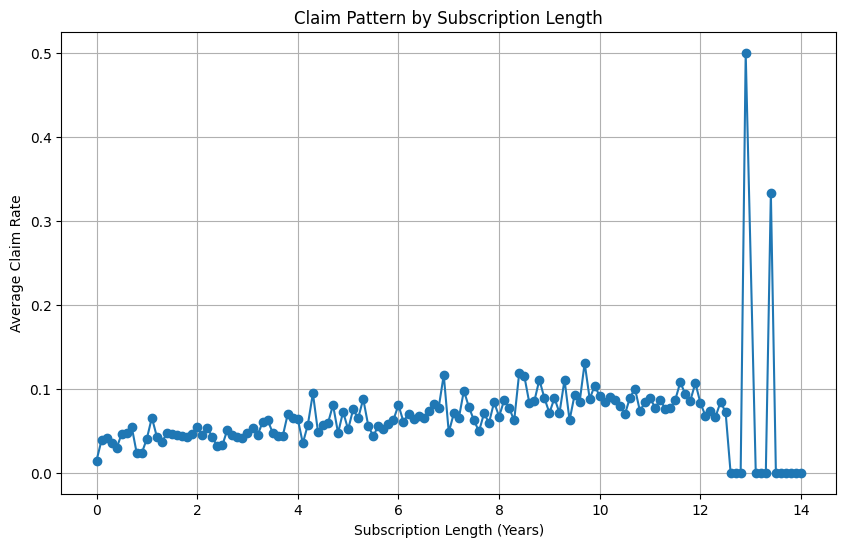

/var/folders/y2/n8qdd_353kb3y187qkv9729c0000gn/T/ipykernel_11724/3188292048.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_claim_rate_bin = df.groupby('subscription_length_bin')['claim_status'].mean().reset_index()


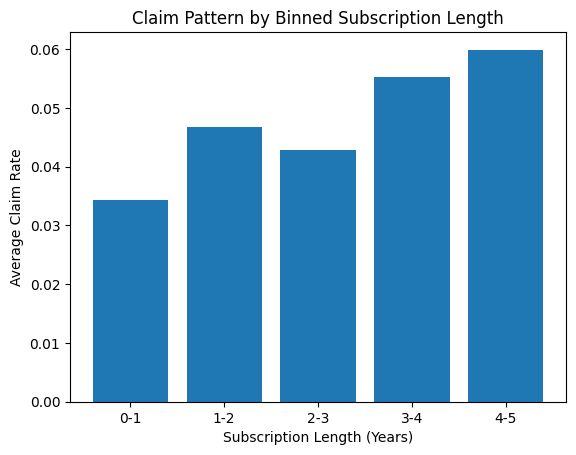

In [148]:
avg_claim_rate = df.groupby('subscription_length')['claim_status'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(avg_claim_rate['subscription_length'], avg_claim_rate['claim_status'], marker='o')
plt.xlabel('Subscription Length (Years)')
plt.ylabel('Average Claim Rate')
plt.title('Claim Pattern by Subscription Length')
plt.grid(True)
plt.show()

df['subscription_length_bin'] = pd.cut(df['subscription_length'], bins=[0,1,2,3,4,5], labels=['0-1','1-2','2-3','3-4','4-5'])
avg_claim_rate_bin = df.groupby('subscription_length_bin')['claim_status'].mean().reset_index()

plt.bar(avg_claim_rate_bin['subscription_length_bin'], avg_claim_rate_bin['claim_status'])
plt.xlabel('Subscription Length (Years)')
plt.ylabel('Average Claim Rate')
plt.title('Claim Pattern by Binned Subscription Length')
plt.show()

High-Risk Feature Combinations
Taken from Analaysis of Association Rules with Respect to Claim Status
By Support:
    rear_brakes_type_1	& transmission_type_1	0.651642	
    transmission_type_1	rear_brakes_type_1	0.651642	
    rear_brakes_type_1	rpm_bin_HighRPM	0.626178
    transmission_type_1	rear_brakes_type_1	0.651642	
    rear_brakes_type_1	rpm_bin_HighRPM	0.626178	
    rpm_bin_HighRPM	rear_brakes_type_1	0.626178